# Analiza danych przestrzennych - ćwiczenia laboratoryjne 2022/2023

Ten notatnik zalicza się do grupy zestawów zadań, na podstawie których odbywa się zaliczenie ćwiczeń i podlega zwrotowi do oceny w ustalonym na zajęciach terminie.

Uwagi ogólne:
- Podczas wykonywania zadań należy korzystać wyłącznie z pakietów zaimportowanych na początku notatnika oraz z pakietów wchodzących w skład standardowej biblioteki Pythona, które można zaimportować samodzielnie we wskazanej komórce.
- Swoje rozwiązania należy wprowadzać wyłącznie w miejce następujących fragmentów kodu:<br/> ` # YOUR CODE HERE`<br/> ` raise NotImplementedError()`<br/> Nie należy w żaden sposób modyfikować pozostałych fragmentów kodu oraz elementów notatnika, w szczególności dodawać lub usuwać komórek oraz zmieniać nazwy pliku.
- Jeżeli zestaw zadań wymaga skorzystania z funkcji przygotowanych w ramach wcześniejszych zestawów zadań należy je umieścić we wskazanej komórce.
- Wszystkie wykresy powinny być wykonane w jednolitym, przejrzystym i czytelnym stylu, mieć nadane tytuły, opisane osie oraz odpowiednio dobrany rozmiar, wielkość punktów i grubość linii. Proporcje osi wykresów przedstawiających rozkłady punktów powinny być dobrane tak, aby wykresy odzwierciedlały rzeczywisty rozkład punktów w przestrzeni.
- Zadania, które powodują wyświetlenie komunikatu o błędzie przerywającym wykonywanie kodu nie podlegają ocenie.

Przed odesłaniem zestawu zadań do oceny proszę uzupełnić komórkę z danymi autorów rozwiązania (`NAME` - nazwa grupy, `COLLABORATORS` - imiona, nazwiska i numery indeksów członków grupy) oraz upewnić się, że notatnik działa zgodnie z oczekiwaniami. W tym celu należy skorzystać z opcji **Restart Kernel and Run All Cells...** dostępnej na górnej belce notatnika pod symbolem $\blacktriangleright\blacktriangleright$. 

In [1]:
COLLABORATORS = "Joanna Nawara Karol Śliwa Marta Kopeć"

---

## Zestaw zadań 5: Badanie relacji między punktami (część 2)

In [11]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Miejsce do importu pakietów wchodzących w skład standardowej biblioteki Pythona oraz ustawienie opcji wykorzystywanych pakietów
sns.set() 
sns.set_theme(style="whitegrid")
import math 

In [13]:
def homogeneous_poisson_on_rectangle(intensity, x_lim, y_lim):
    """
    Parameters
    -------
    intensity: float
        Liczba dodatnia określająca intensywność procesu punktowego.
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   
    
    Returns
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    """ 
    xDelta=x_lim[1]-x_lim[0];
    yDelta=y_lim[1]-y_lim[0];
    areaTotal=xDelta*yDelta;
    
    numbPoints = sp.stats.poisson( intensity*areaTotal ).rvs() 
    x = xDelta*sp.stats.uniform.rvs(0,1,(1, numbPoints))+x_lim[0]
    y = yDelta*sp.stats.uniform.rvs(0,1,(1, numbPoints))+y_lim[0]
    data={'X':x.ravel(), 'Y':y.ravel()}
    return pd.DataFrame(data)

def regular_on_rectangle(grid, random_component, x_lim, y_lim):
    """
    Parameters
    -------
    grid: list
        Lista określająca liczbę punktów w pionie i poziomie.
        Przykład: [10, 10]
    random_component: float
        Liczba z przedziału [0, 1] określająca wielkość komponentu losowego.
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   

    Returns
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    """
    dx = (x_lim[1]-x_lim[0])/grid[0]
    dy = (y_lim[1]-y_lim[0])/grid[1]
    
    x = np.arange(x_lim[0]+dx/2, x_lim[1], dx)
    y = np.arange(y_lim[0]+dy/2, y_lim[1], dy)
    
    xx, yy = np.meshgrid(x, y)
    
    rx = np.random.uniform(-dx/2, dx/2, size = xx.shape[0]*xx.shape[1]) * random_component
    ry = np.random.uniform(-dy/2, dy/2, size = yy.shape[0]*yy.shape[1]) * random_component
    
    new_x = xx.ravel() + rx
    new_y = yy.ravel() + ry
    
    df = {'X' : new_x, 'Y' : new_y}
    df = pd.DataFrame(df)
    return df


def materna_on_rectangle(parent_intensity, daughter_intensity, cluster_radius, x_lim, y_lim):
    """
    Parameters
    -------
    parent_intensity: float
        Liczba dodatnia określająca intensywność macierzystego procesu punktowego.
    daughter_intensity: float
        Liczba dodatnia określająca intensywność potomnego procesu punktowego.
    cluster_radius: float
        Liczba dodatnia określająca promień generowanych klastrów.
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   
    
    Returns
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    """
    
    # Extended simulation windows parameters
    x_lim_new = [x_lim[0]-cluster_radius, x_lim[1]+cluster_radius]
    y_lim_new = [y_lim[0]-cluster_radius, y_lim[1]+cluster_radius]
    
    # Simulate Poisson point process for the parents
    parent_points =  homogeneous_poisson_on_rectangle(parent_intensity, x_lim_new, y_lim_new)
    num_parent = len(parent_points)
    
    # Number of daughters points per cluster
    circle_area = np.pi*cluster_radius**2
    num_daughter = sp.stats.poisson( daughter_intensity*circle_area ).rvs()
    
    total_number = num_parent * num_daughter
    
    # Generate polar variables
    r = cluster_radius * np.sqrt(np.random.uniform(0, 1, total_number));
    angle = 2 * np.pi * np.random.uniform(0, 1, total_number);
    
    # Convert from polar to Cartesian coordinates
    daughter_x = r * np.cos(angle)
    daughter_y = r * np.sin(angle)
    
    # Replicate parents
    parent_x = np.repeat(parent_points.X, num_daughter)
    parent_y = np.repeat(parent_points.Y, num_daughter)
    
    # Translate points
    new_x = parent_x + daughter_x
    new_y = parent_y + daughter_y
    
    # Accept points inside the simulation window
    insideWindow = ((new_x >= x_lim[0]) & (new_x <= x_lim[1]) & (new_y >= y_lim[0]) & (new_y <= y_lim[1]))
    new_x = new_x[insideWindow]
    new_x.reset_index(inplace=True, drop=True)
    new_y = new_y[insideWindow]
    new_y.reset_index(inplace=True, drop=True)
    
    # Pass data to the DataFrame
    data = {'X': new_x, 'Y': new_y}
    data = pd.DataFrame(data)
    #data = data.reset_index()
    
    return data

### Przygotowanie danych

Korzystając z funkcji przygotowanych w ramach pierwszego zestawu zadań wygeneruj rozkłady punktowe o podanych paramatrach.

Jednorodny rozkład Poissona:
 - intensywność procesu: 2.5

Rozkład regularny z komponentem losowym:
- liczba punktów w poziomie i w pionie: 15x15
- komponent losowy: 0.75

Rozkład Materna:
 - intensywność procesu macierzystego: 0.3
 - intensywność procesu potomnego: 5
 - promień klastra: 0.75
 
Parametry identyczne dla wszystkich rozkładów:
 - zakres wartości współrzędnej x: [0, 10]
 - zakres wartości współrzędnej y: [0, 10]
 
UWAGA! Dane do wygenerowania są identyczne jak w poprzednim zestawie zadań.

In [14]:
x_lim = [0,10]
y_lim = [0,10]

points_R = regular_on_rectangle([15,15], 0.75, x_lim, y_lim)
points_M = materna_on_rectangle(0.3, 5, 0.75, x_lim, y_lim)
points_HP = homogeneous_poisson_on_rectangle(2.5, x_lim, y_lim)
points_HP_test = homogeneous_poisson_on_rectangle(2.5, x_lim, y_lim)

### Zadanie 1: Funkcja G (25 pkt)

Przygotuj funkcję `g_function()`, która będzie generować dane niezbędne do wykonania wykresu funkcji G analizowanego rozkładu punktów oraz funkcję `g_function_poisson()`, która będzie generować dane niezbędne do wykonania wykresu teoretycznej funkcji G jednorodnego rozkładu Poissona danej wzorem: <br/>
$G(d) = 1 - exp(-\lambda \pi d^2)$ <br/>
gdzie: $\lambda$ - intensywność procesu, $d$ - odległość.

Następnie wykorzystaj przygotowane funkcje do wygnenerowania danych dla wszystkich przygotowanych rozkładów punktów. 

Przedstaw wyniki analizy graficznie w postaci wykresów liniowych funkcji G przygotowanych rozkładów punktów zestawionych z teoretyczną funkcją G jednorodnego rozkładu Poissona o intensywności $2.5$. Zestaw wyniki na pojedynczej figurze (siatka wykresów 2x3). Umieść analizowane rozkłady punktów w górnym wierszu, a wykresy funkcji G w dolnym wierszu figury. <br/>
Uwaga! Porównywane wykresy funkcji G powinny zaczynać się od $d=0$ (co może wymagać uzupełnienia danych o 0 w obrębie funkcji `g_function()`) i kończyć na wartości $d$, dla której funkcja G analizowanego rozkładu punktów osiąga wartość 1.

Algorytm postępowania:
1) Dla każdego z punktów analizowanego rozkładu wyliczamy dystans do jego najbliższego sąsiada $d_{min}$.
2) Konstruujemy funkcję G jako dystrybuantę rozkładu odległości: <br/>
    $G(d) = \frac{n_{d_{min} \le d}}{n}$  <br/>
    gdzie: $n_{d_{min} \le d}$ - liczba punktów, dla których odległość do najbliższego sąsiada $d_{min}$ jest mniejsza lub równa $d$, $n$ - liczba punktów.

#### a) Przygotowanie funkcji

In [15]:
def g_function(points):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    
    Returns
    -------
    g: DataFrame
        Tablica zawierająca dwie kolumny:
        - "D" - zawierającą unikalne wartości odległości do najbliższego sąsiada uszeregowane od najmniejszej do największej wartości, dla których wyliczone zostały wartości funkcji G,
        - "G" - zawierającą wyliczone wartości funkcji G.
    """   
    result = sp.spatial.distance.cdist(points, points)
    Dmin = len(points.X)
    dl = []
    for i in range(Dmin):
        dl.append(np.sort(result[i])[1])
        
    dl = np.sort(dl)
    unique, counts = np.unique(dl, return_counts=True)
    
    G = counts/Dmin
    G = np.cumsum(G)
    
    G = np.insert(G, 0, 0)
    unique = np.insert(unique, 0, 0)
    g = pd.DataFrame({'D':unique, 'G':G})
    return g
        
def g_function_poisson(d, intensity):
    """
    Parameters
    -------
    d: array
        Macierz zawierająca odległości, dla których ma zostać wyznaczona wartość funkcji G.
    intensity: float
        Liczba dodatnia określająca intensywność jednorodnego procesu Poissona.
    
    Returns
    -------
    g: DataFrame
        Tablica zawierająca dwie kolumny:
        - "D" - zawierającą unikalne wartości odległości do najbliższego sąsiada uszeregowane od najmniejszej do największej wartości, dla których wyliczone zostały wartości funkcji G,
        - "G" - zawierającą wyliczone wartości funkcji G.
    """  
    G = []
    for i in range(len(d)):
        G.append(1-np.exp(-intensity*np.pi*d[i]**2))
        
    return pd.DataFrame({'D':d, 'G':G})

    

#### b) Wygenerowanie danych

In [16]:
# YOUR CODE HERE
G_R=g_function(points_R)
G_M=g_function(points_M)
G_HP=g_function(points_HP)
G_HP_t=g_function_poisson(G_HP.D, 2.5)

#### c) Wizualizacja

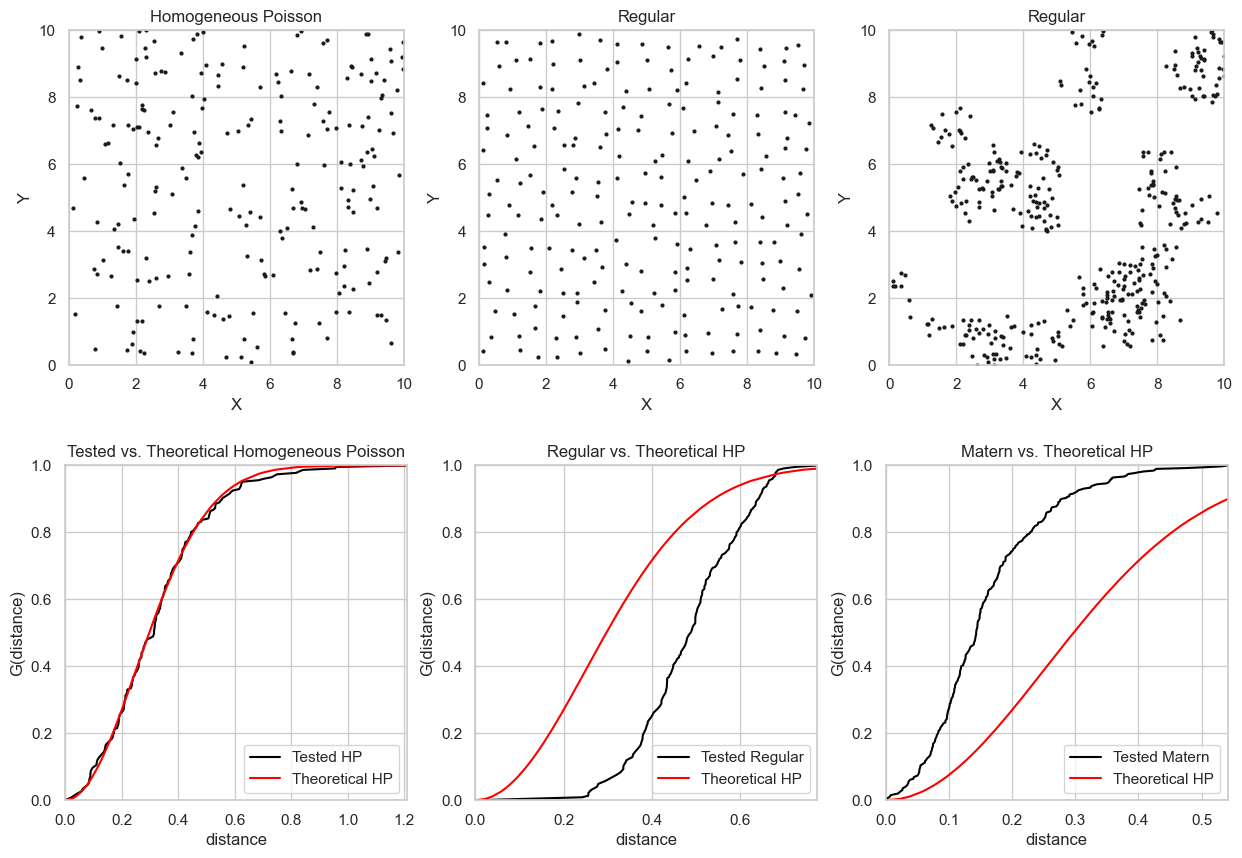

In [17]:
# YOUR CODE HERE
#figura 2x3: punkty gorna i wykresy G w dolnej czesci

fig, ax = plt.subplots(2,3,figsize=(15, 10))

f_y_lim = [0, 1]

ax[0,0].scatter(points_HP.X, points_HP.Y, s = 4, c='k')
ax[0,0].set_aspect('equal')
ax[0,0].set_title("Homogeneous Poisson")
ax[0,0].set_xlim(x_lim)
ax[0,0].set_ylim(y_lim)
ax[0,0].set_xlabel("X")
ax[0,0].set_ylabel("Y")

sns.lineplot(data = G_HP, x = "D", y="G", ax=ax[1,0], color='black', legend='brief', label="Tested HP")
sns.lineplot(data = G_HP_t, x = "D", y="G", ax=ax[1,0], color='red', legend='brief', label="Theoretical HP")
ax[1,0].set_title("Tested vs. Theoretical Homogeneous Poisson")
ax[1,0].legend(loc='lower right')
ax[1,0].set_xlabel("distance")
ax[1,0].set_ylabel("G(distance)")
ax[1,0].set_xlim([0, G_HP.D.iloc[-1]])
ax[1,0].set_ylim(f_y_lim)

ax[0,1].scatter(points_R.X, points_R.Y, s = 4, c='k')
ax[0,1].set_aspect('equal')
ax[0,1].set_title("Regular")
ax[0,1].set_xlim(x_lim)
ax[0,1].set_ylim(y_lim)
ax[0,1].set_xlabel("X")
ax[0,1].set_ylabel("Y")

sns.lineplot(data = G_R, x = "D", y="G", ax=ax[1,1], color='black', legend='brief', label="Tested Regular")
sns.lineplot(data = G_HP_t, x = "D", y="G", ax=ax[1,1], color='red', legend='brief', label="Theoretical HP")
ax[1,1].set_title("Regular vs. Theoretical HP")
ax[1,1].legend(loc='lower right')
ax[1,1].set_xlabel("distance")
ax[1,1].set_ylabel("G(distance)")
ax[1,1].set_xlim([0, G_R.D.iloc[-1]])
ax[1,1].set_ylim(f_y_lim)

ax[0,2].scatter(points_M.X, points_M.Y, s = 4, c='k')
ax[0,2].set_aspect('equal')
ax[0,2].set_title("Regular")
ax[0,2].set_xlim(x_lim)
ax[0,2].set_ylim(y_lim)
ax[0,2].set_xlabel("X")
ax[0,2].set_ylabel("Y")

sns.lineplot(data = G_M, x = "D", y="G", ax=ax[1,2], color='black', legend='brief', label="Tested Matern")
sns.lineplot(data = G_HP_t, x = "D", y="G", ax=ax[1,2], color='red', legend='brief', label="Theoretical HP")
ax[1,2].set_title("Matern vs. Theoretical HP")
ax[1,2].legend(loc='lower right')
ax[1,2].set_xlabel("distance")
ax[1,2].set_ylabel("G(distance)")
ax[1,2].set_xlim([0, G_M.D.iloc[-1]])
ax[1,2].set_ylim(f_y_lim)

plt.subplots_adjust(hspace = 0.3)
plt.show()

### Zadanie 2: Funkcja F (25 pkt)

Przygotuj funkcję `f_function()`, która będzie generować dane niezbędne do wykonania wykresu funkcji F analizowanego rozkładu punktów oraz funkcję `f_function_poisson()`, która będzie generować  dane niezbędne do wykonania wykresu teoretycznej funkcji F jednorodnego rozkładu Poissona danej wzorem: <br/>
$F(d) = 1 - exp(-\lambda \pi d^2)$ <br/>
gdzie: $\lambda$ - intensywność procesu, $d$ - odległość.

Następnie wykorzystaj przygotowane funkcje do wygnenerowania danych dla wszystkich przygotowanych rozkładów punktów. 

Przedstaw wyniki analizy graficznie w postaci wykresów liniowych funkcji F przygotowanych rozkładów punktów zestawionych z teoretyczną funkcją F jednorodnego rozkładu Poissona o intensywności $2.5$. Zestaw wyniki na pojedynczej figurze (siatka wykresów 2x3). Umieść analizowane rozkłady punktów w górnym wierszu, a wykresy funkcji F w dolnym wierszu figury. <br/>
Uwaga! Porównywane wykresy funkcji F powinny zaczynać się od $d=0$ (co może wymagać uzupełnienia danych o 0 w obrębie funkcji `f_function()`) i kończyć na wartości $d$, dla której funkcja F analizowanego rozkładu punktów osiąga wartość 1.

Algorytm postępowania:
1) Z wykorzystaniem procesu regularnego lub jednorodnego procesu Poissona generujemy w obrębie analizowanego rozkładu zestaw punktów pomiarowych.
2) Dla każdego z punktów rozkładu pomiarowego wyliczamy dystans do jego najbliższego sąsiada z analizowanego rozkładu $d_{min}$.
3) Konstruujemy funkcję F jako dystrybuantę rozkładu odległości: <br/>
    $F(d) = \frac{n_{d_{min} \le d}}{n}$  <br/>
    gdzie: $n_{d_{min} \le d}$ - liczba punktów rozkładu pomiarowego, dla których odległość do najbliższego sąsiada z analizowanego rozkładu $d_{min}$ jest mniejsza lub równa $d$, $n$ - liczba punktów rozkładu pomiarowego.
    
Uwaga! Liczba punktów rozkładu pomiarowego jest istotna i wpływa na dokładność rozwiązania.

#### a) Przygotowanie funkcji

In [20]:
def f_function(points, test_points):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów analizowanego rozkłądu opisane jako "X" i "Y".
    test_points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów pomiarowych, dla których mają zostać wyznaczone odległości
        do najbliższego sąsiada z analizowanego rozkładu opisane jako "X" i "Y".
    
    Returns
    -------
    f: DataFrame
        Tablica zawierająca dwie kolumny:
        - "D" - zawierającą unikalne wartości odległości do najbliższego sąsiada uszeregowane od najmniejszej do największej wartości, dla których wyliczone zostały wartości funkcji F,
        - "F" - zawierającą wyliczone wartości funkcji F.
    """   
    
    D = sp.spatial.distance.cdist(test_points,points, 'euclidean')
    
    D = np.sort(D,axis=1)
    Ds = D[:,0]
    Du,counts = np.unique(Ds, return_counts=True)
    
    N=len(Ds)
    F=counts/N
    F=np.cumsum(F)

    Du = np.insert(Du,0,0)
    F = np.insert(F,0,0)
    
    return pd.DataFrame({"D":Du,"F":F})
    
def f_function_poisson(d, intensity):
    """
    Parameters
    -------
    d: array
        Macierz zawierająca odległości, dla których ma zostać wyznaczona wartość funkcji F.
    intensity: float
        Liczba dodatnia określająca intensywność jednorodnego procesu Poissona.

    Returns
    -------
    f: DataFrame
        Tablica zawierająca dwie kolumny:
        - "D" - zawierającą unikalne wartości odległości do najbliższego sąsiada uszeregowane od najmniejszej do największej wartości, dla których wyliczone zostały wartości funkcji F,
        - "F" - zawierającą wyliczone wartości funkcji F.
    """  
    
    F = 1-np.exp(-intensity*np.pi*d**2)
    return pd.DataFrame({"D":d,"F":F})


#### b) Wygenerowanie danych

In [21]:
df_HP = f_function(points_HP, points_HP_test)
df_R = f_function(points_R, points_HP_test)
df_M = f_function(points_M, points_HP_test)

df_Theor = f_function_poisson(df_HP.D, 2.5)

#### c) Wizualizacja

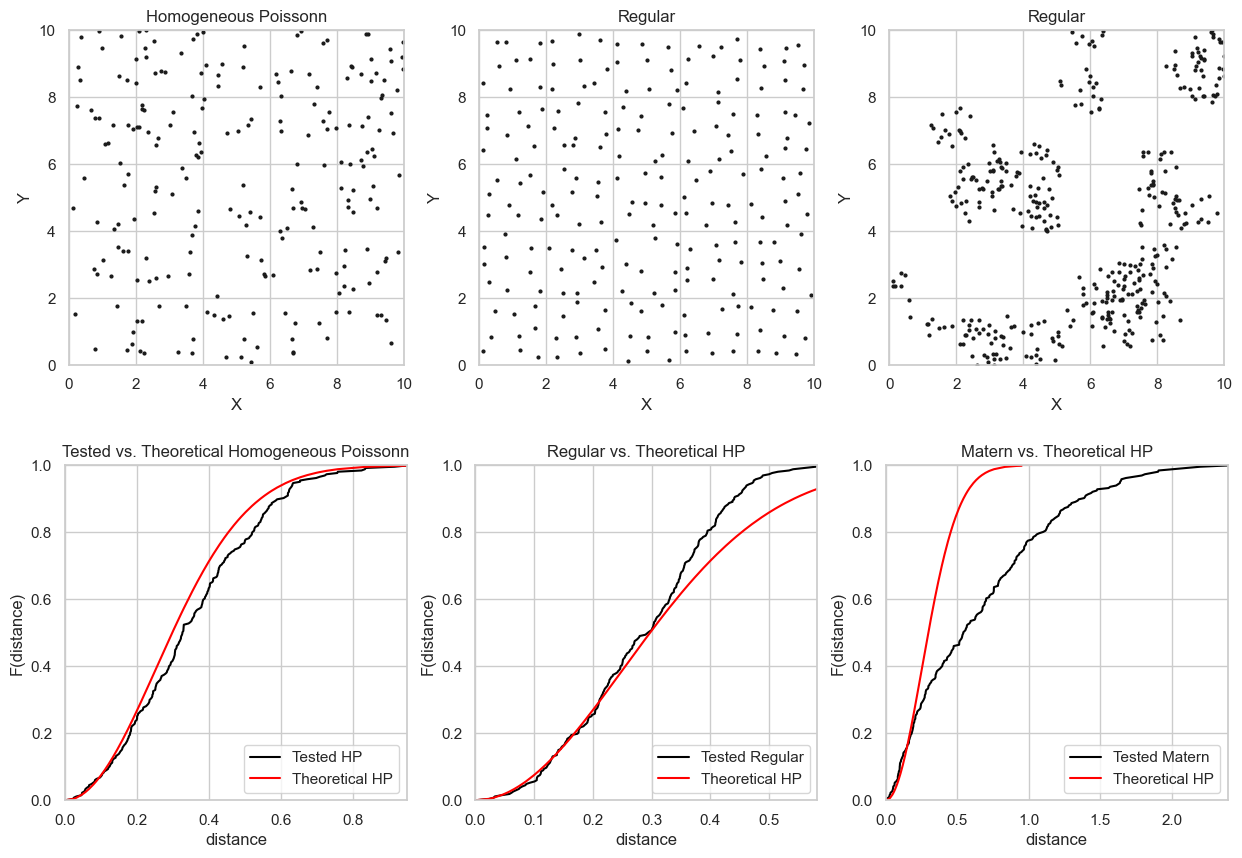

In [22]:
fig, ax = plt.subplots(2,3,figsize=(15, 10))

f_y_lim = [0, 1]

ax[0,0].scatter(points_HP.X, points_HP.Y, s = 4, c='k')
ax[0,0].set_aspect('equal')
ax[0,0].set_title("Homogeneous Poissonn")
ax[0,0].set_xlim(x_lim)
ax[0,0].set_ylim(y_lim)
ax[0,0].set_xlabel("X")
ax[0,0].set_ylabel("Y")

sns.lineplot(data = df_HP, x = "D", y="F", ax=ax[1,0], color='black', legend='brief', label="Tested HP")
sns.lineplot(data = df_Theor, x = "D", y="F", ax=ax[1,0], color='red', legend='brief', label="Theoretical HP")
ax[1,0].set_title("Tested vs. Theoretical Homogeneous Poissonn")
#ax[1,0].set_aspect('equal')
ax[1,0].legend(loc='lower right')
ax[1,0].set_xlabel("distance")
ax[1,0].set_ylabel("F(distance)")
ax[1,0].set_xlim([0, df_HP.D.iloc[-1]])
ax[1,0].set_ylim(f_y_lim)

ax[0,1].scatter(points_R.X, points_R.Y, s = 4, c='k')
ax[0,1].set_aspect('equal')
ax[0,1].set_title("Regular")
ax[0,1].set_xlim(x_lim)
ax[0,1].set_ylim(y_lim)
ax[0,1].set_xlabel("X")
ax[0,1].set_ylabel("Y")

sns.lineplot(data = df_R, x = "D", y="F", ax=ax[1,1], color='black', legend='brief', label="Tested Regular")
sns.lineplot(data = df_Theor, x = "D", y="F", ax=ax[1,1], color='red', legend='brief', label="Theoretical HP")
ax[1,1].set_title("Regular vs. Theoretical HP")
#ax[1,0].set_aspect('equal')
ax[1,1].legend(loc='lower right')
ax[1,1].set_xlabel("distance")
ax[1,1].set_ylabel("F(distance)")
ax[1,1].set_xlim([0, df_R.D.iloc[-1]])
ax[1,1].set_ylim(f_y_lim)

ax[0,2].scatter(points_M.X, points_M.Y, s = 4, c='k')
ax[0,2].set_aspect('equal')
ax[0,2].set_title("Regular")
ax[0,2].set_xlim(x_lim)
ax[0,2].set_ylim(y_lim)
ax[0,2].set_xlabel("X")
ax[0,2].set_ylabel("Y")

sns.lineplot(data = df_M, x = "D", y="F", ax=ax[1,2], color='black', legend='brief', label="Tested Matern")
sns.lineplot(data = df_Theor, x = "D", y="F", ax=ax[1,2], color='red', legend='brief', label="Theoretical HP")
ax[1,2].set_title("Matern vs. Theoretical HP")
#ax[1,2].set_aspect('equal')
ax[1,2].legend(loc='lower right')
ax[1,2].set_xlabel("distance")
ax[1,2].set_ylabel("F(distance)")
ax[1,2].set_xlim([0, df_M.D.iloc[-1]])
ax[1,2].set_ylim(f_y_lim)

plt.subplots_adjust(hspace = 0.3)
plt.show()